In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import glob
import matplotlib.pyplot as plt

from torch.utils.data import ConcatDataset, DataLoader
from catalyst import dl
from catalyst.utils import metrics
from torch.nn import functional as F

from vxs import *

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [2]:
torch.cuda.is_available()

False

In [3]:
vocal_sketch_dataset = SampleSet(glob.glob('../data/vocal_imitations_sketch_included/included/*.wav'))
drum_machines_dataset = SampleSet(glob.glob('../data/200DrumMachines/*/*.wav'))
avp_set_fixed = SampleSet(tracks=SegmentSet(AVPTrackSet('../data/AVP_Dataset', subset='Fixed'), return_class=False))
common_set = ConcatDataset([vocal_sketch_dataset, drum_machines_dataset, avp_set_fixed])

In [4]:
len(common_set)

16075

In [5]:
len(drum_machines_dataset)

6749

In [6]:
len(vocal_sketch_dataset)

4429

In [7]:
splitter = DataSplit(common_set, shuffle=True, test_train_split=1)
loaders = {
    'train': splitter.get_train_loader(),
    'valid': splitter.get_validation_loader()
}

model = ConvAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
class ConvAERunner(dl.Runner):
    def _handle_batch(self, batch):
        x = batch          # ignore the raw waveform
        y, z = self.model(x)
        loss = F.mse_loss(y, x)
        self.batch_metrics = {
            'loss': loss
        }
        
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

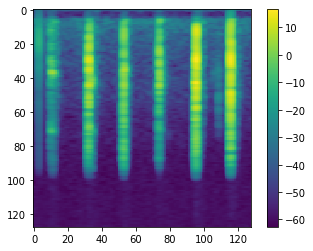

In [9]:
def sample_random(num, ln, seed):
    np.random.seed(seed)
    return np.random.randint(0, ln, size=num)

def imshow_random_samples(dataset, num, random_seed=42, cols=3):
    samples = sample_random(num, len(dataset), random_seed)
    rows = num // cols + (0 if num % cols == 0 else 1)
    fig, axes_t = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = [ax for tp in axes_t for ax in tp]
    
    for (sample_idx, ax) in zip(samples, axes):
        sample = dataset[sample_idx]
        ax.imshow(sample.squeeze(0).numpy())
        ax.set_title(sample_idx)
        
    plt.show()
    
def imshow_ae_output(model, dataset, num, random_seed=42):
    samples = sample_random(num, len(dataset), random_seed)
    fig, axes = plt.subplots(num, 3, figsize=(12, 4*num))
    
    for (sample_idx, (ax1, ax2, ax3)) in zip(samples, axes):
        sample = dataset[sample_idx]
        sample_out, z = model(sample.unsqueeze(0))
        ax1.imshow(sample.squeeze().numpy())
        ax2.imshow(sample_out.detach().squeeze().numpy())
        ax3.imshow(z.detach().squeeze().flatten(1).numpy())
        
    plt.show()
    
melgram = common_set[42][0]
im = plt.imshow(melgram.squeeze(0).numpy())
plt.colorbar(im)
plt.show()

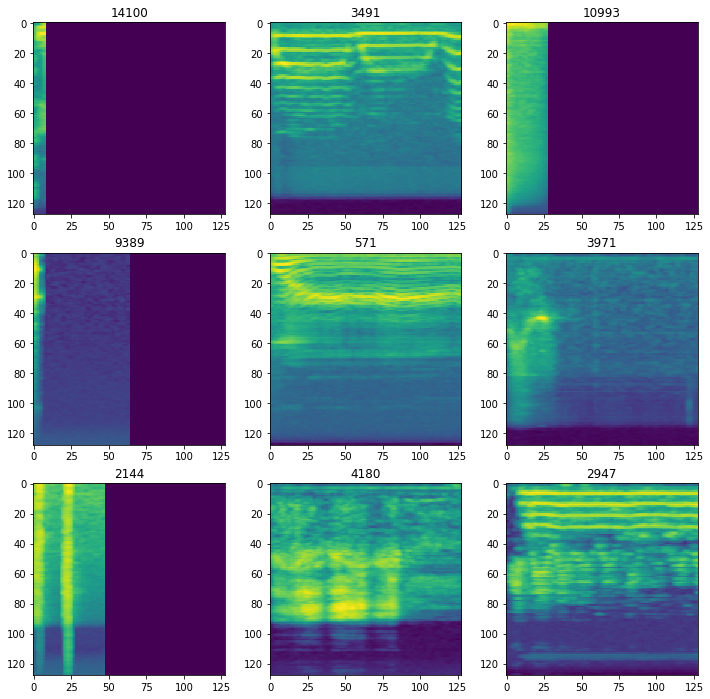

In [10]:
imshow_random_samples(common_set, 9, random_seed=44, cols=3)

In [11]:
#model.load_state_dict(torch.load('../logs/conv_ae_3/checkpoints/train.19.pth')['model_state_dict'])
#model.eval()

In [12]:
#imshow_ae_output(model, common_set, 10)

In [13]:
runner = ConvAERunner()
runner.train(
    model=model, 
    optimizer=optimizer, 
    loaders=loaders,
    num_epochs=20,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_added_3"
)

1/20 * Epoch (train): 100% 290/290 [05:44<00:00,  1.19s/it, loss=6406.146]
1/20 * Epoch (valid): 100% 33/33 [00:28<00:00,  1.18it/s, loss=6334.476]
[2020-07-14 23:58:47,721] 
1/20 * Epoch 1 (train): loss=6315.8244
1/20 * Epoch 1 (valid): loss=6306.6890


INFO:metrics_logger:
1/20 * Epoch 1 (train): loss=6315.8244
1/20 * Epoch 1 (valid): loss=6306.6890


2/20 * Epoch (train): 100% 290/290 [05:26<00:00,  1.13s/it, loss=6808.018]
2/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.22it/s, loss=6922.455]
[2020-07-15 00:04:42,163] 
2/20 * Epoch 2 (train): loss=6315.0971
2/20 * Epoch 2 (valid): loss=6320.6457


INFO:metrics_logger:
2/20 * Epoch 2 (train): loss=6315.0971
2/20 * Epoch 2 (valid): loss=6320.6457


3/20 * Epoch (train): 100% 290/290 [05:32<00:00,  1.15s/it, loss=6729.177]
3/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=5711.554]
[2020-07-15 00:10:42,468] 
3/20 * Epoch 3 (train): loss=6314.0998
3/20 * Epoch 3 (valid): loss=6290.0581


INFO:metrics_logger:
3/20 * Epoch 3 (train): loss=6314.0998
3/20 * Epoch 3 (valid): loss=6290.0581


4/20 * Epoch (train): 100% 290/290 [05:30<00:00,  1.14s/it, loss=8152.097]
4/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=4755.169]
[2020-07-15 00:16:41,233] 
4/20 * Epoch 4 (train): loss=6316.5365
4/20 * Epoch 4 (valid): loss=6263.5984


INFO:metrics_logger:
4/20 * Epoch 4 (train): loss=6316.5365
4/20 * Epoch 4 (valid): loss=6263.5984


5/20 * Epoch (train): 100% 290/290 [05:27<00:00,  1.13s/it, loss=6946.490]
5/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=5061.229]
[2020-07-15 00:22:36,913] 
5/20 * Epoch 5 (train): loss=6313.1341
5/20 * Epoch 5 (valid): loss=6270.5008


INFO:metrics_logger:
5/20 * Epoch 5 (train): loss=6313.1341
5/20 * Epoch 5 (valid): loss=6270.5008


6/20 * Epoch (train): 100% 290/290 [05:53<00:00,  1.22s/it, loss=4709.372]
6/20 * Epoch (valid): 100% 33/33 [00:31<00:00,  1.04it/s, loss=8189.772]
[2020-07-15 00:29:02,879] 
6/20 * Epoch 6 (train): loss=6307.6980
6/20 * Epoch 6 (valid): loss=6350.9802


INFO:metrics_logger:
6/20 * Epoch 6 (train): loss=6307.6980
6/20 * Epoch 6 (valid): loss=6350.9802


7/20 * Epoch (train): 100% 290/290 [05:51<00:00,  1.21s/it, loss=5774.677]
7/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.20it/s, loss=5093.962]
[2020-07-15 00:35:22,788] 
7/20 * Epoch 7 (train): loss=6309.6690
7/20 * Epoch 7 (valid): loss=6270.6962


INFO:metrics_logger:
7/20 * Epoch 7 (train): loss=6309.6690
7/20 * Epoch 7 (valid): loss=6270.6962


8/20 * Epoch (train): 100% 290/290 [05:28<00:00,  1.13s/it, loss=6727.791]
8/20 * Epoch (valid): 100% 33/33 [00:26<00:00,  1.23it/s, loss=5828.072]
[2020-07-15 00:41:18,086] 
8/20 * Epoch 8 (train): loss=6311.4224
8/20 * Epoch 8 (valid): loss=6289.0596


INFO:metrics_logger:
8/20 * Epoch 8 (train): loss=6311.4224
8/20 * Epoch 8 (valid): loss=6289.0596


9/20 * Epoch (train): 100% 290/290 [05:34<00:00,  1.15s/it, loss=7004.314]
9/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=7756.483]
[2020-07-15 00:47:19,949] 
9/20 * Epoch 9 (train): loss=6311.7304
9/20 * Epoch 9 (valid): loss=6337.4908


INFO:metrics_logger:
9/20 * Epoch 9 (train): loss=6311.7304
9/20 * Epoch 9 (valid): loss=6337.4908


10/20 * Epoch (train): 100% 290/290 [05:29<00:00,  1.14s/it, loss=5500.040]
10/20 * Epoch (valid): 100% 33/33 [00:26<00:00,  1.23it/s, loss=6986.208]
[2020-07-15 00:53:17,213] 
10/20 * Epoch 10 (train): loss=6308.1166
10/20 * Epoch 10 (valid): loss=6318.0706


INFO:metrics_logger:
10/20 * Epoch 10 (train): loss=6308.1166
10/20 * Epoch 10 (valid): loss=6318.0706


11/20 * Epoch (train): 100% 290/290 [05:34<00:00,  1.15s/it, loss=6830.128]
11/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.20it/s, loss=5654.808]
[2020-07-15 00:59:19,440] 
11/20 * Epoch 11 (train): loss=6310.9563
11/20 * Epoch 11 (valid): loss=6283.7748


INFO:metrics_logger:
11/20 * Epoch 11 (train): loss=6310.9563
11/20 * Epoch 11 (valid): loss=6283.7748


12/20 * Epoch (train): 100% 290/290 [05:27<00:00,  1.13s/it, loss=5295.582]
12/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.20it/s, loss=6610.116]
[2020-07-15 01:05:15,062] 
12/20 * Epoch 12 (train): loss=6307.1950
12/20 * Epoch 12 (valid): loss=6307.9613


INFO:metrics_logger:
12/20 * Epoch 12 (train): loss=6307.1950
12/20 * Epoch 12 (valid): loss=6307.9613


13/20 * Epoch (train): 100% 290/290 [05:30<00:00,  1.14s/it, loss=7112.320]
13/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=8605.279]
[2020-07-15 01:11:12,945] 
13/20 * Epoch 13 (train): loss=6311.2526
13/20 * Epoch 13 (valid): loss=6358.6901


INFO:metrics_logger:
13/20 * Epoch 13 (train): loss=6311.2526
13/20 * Epoch 13 (valid): loss=6358.6901


14/20 * Epoch (train): 100% 290/290 [05:28<00:00,  1.13s/it, loss=5335.458]
14/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=4617.249]
[2020-07-15 01:17:09,479] 
14/20 * Epoch 14 (train): loss=6307.0868
14/20 * Epoch 14 (valid): loss=6257.0595


INFO:metrics_logger:
14/20 * Epoch 14 (train): loss=6307.0868
14/20 * Epoch 14 (valid): loss=6257.0595


15/20 * Epoch (train): 100% 290/290 [05:33<00:00,  1.15s/it, loss=7253.592]
15/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=5161.285]
[2020-07-15 01:23:10,481] 
15/20 * Epoch 15 (train): loss=6314.5369
15/20 * Epoch 15 (valid): loss=6281.8368


INFO:metrics_logger:
15/20 * Epoch 15 (train): loss=6314.5369
15/20 * Epoch 15 (valid): loss=6281.8368


16/20 * Epoch (train): 100% 290/290 [05:29<00:00,  1.14s/it, loss=6239.471]
16/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=3717.957]
[2020-07-15 01:29:07,678] 
16/20 * Epoch 16 (train): loss=6311.7340
16/20 * Epoch 16 (valid): loss=6235.5787


INFO:metrics_logger:
16/20 * Epoch 16 (train): loss=6311.7340
16/20 * Epoch 16 (valid): loss=6235.5787


17/20 * Epoch (train): 100% 290/290 [05:29<00:00,  1.14s/it, loss=6742.014]
17/20 * Epoch (valid): 100% 33/33 [00:26<00:00,  1.22it/s, loss=7822.476]
[2020-07-15 01:35:04,894] 
17/20 * Epoch 17 (train): loss=6311.4334
17/20 * Epoch 17 (valid): loss=6340.0545


INFO:metrics_logger:
17/20 * Epoch 17 (train): loss=6311.4334
17/20 * Epoch 17 (valid): loss=6340.0545


18/20 * Epoch (train): 100% 290/290 [05:30<00:00,  1.14s/it, loss=6933.485]
18/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=5912.783]
[2020-07-15 01:41:02,885] 
18/20 * Epoch 18 (train): loss=6311.3952
18/20 * Epoch 18 (valid): loss=6290.5080


INFO:metrics_logger:
18/20 * Epoch 18 (train): loss=6311.3952
18/20 * Epoch 18 (valid): loss=6290.5080


19/20 * Epoch (train): 100% 290/290 [05:31<00:00,  1.14s/it, loss=5423.384]
19/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.21it/s, loss=6184.136]
[2020-07-15 01:47:01,745] 
19/20 * Epoch 19 (train): loss=6307.6645
19/20 * Epoch 19 (valid): loss=6297.7688


INFO:metrics_logger:
19/20 * Epoch 19 (train): loss=6307.6645
19/20 * Epoch 19 (valid): loss=6297.7688


20/20 * Epoch (train): 100% 290/290 [05:30<00:00,  1.14s/it, loss=5954.638]
20/20 * Epoch (valid): 100% 33/33 [00:27<00:00,  1.20it/s, loss=4616.843]
[2020-07-15 01:53:00,405] 
20/20 * Epoch 20 (train): loss=6308.7482
20/20 * Epoch 20 (valid): loss=6257.3136


INFO:metrics_logger:
20/20 * Epoch 20 (train): loss=6308.7482
20/20 * Epoch 20 (valid): loss=6257.3136


Top best models:
../logs/conv_ae_added_3/checkpoints/train.16.pth	6235.5787


In [ ]:
vocal_splitter = DataSplit(vocal_sketch_dataset, shuffle=True, test_train_split=1)
vocal_loaders = {
    'train': vocal_splitter.get_train_loader(),
    'valid': vocal_splitter.get_validation_loader()
}

In [ ]:
vocal_model = ConvAE()
vocal_optimizer = torch.optim.Adam(vocal_model.parameters())

In [ ]:
vocal_runner = ConvAERunner()
vocal_runner.train(
    model=vocal_model, 
    optimizer=vocal_optimizer, 
    loaders=vocal_loaders,
    num_epochs=10,
    verbose=True,
    timeit=False,
    logdir="../logs/conv_ae_vocal_only"
)

In [ ]:
imshow_ae_output(vocal_model, vocal_sketch_dataset, 10)

In [ ]:
vocal_sketch_dataset_unnorm = SampleSet(glob.glob('../data/vocal_imitations_sketch_included/included/*.wav'))
drum_machines_dataset_unnorm = SampleSet(glob.glob('../data/200DrumMachines/*/*.wav'))
common_set_unnorm = ConcatDataset([vocal_sketch_dataset_unnorm, drum_machines_dataset_unnorm])

In [ ]:
model_unnorm = ConvAE()
model_unnorm.load_state_dict(torch.load('../logs/conv_ae_2/checkpoints/train.20.pth')['model_state_dict'])

In [ ]:
imshow_ae_output(model_unnorm, common_set_unnorm, 10)